   num      date_time  Power Consumption (kWh)  Temperature (°C)  \
0    1  2020-06-01 00                 8179.056              17.6   
1    1  2020-06-01 01                 8135.640              17.7   
2    1  2020-06-01 02                 8107.128              17.5   
3    1  2020-06-01 03                 8048.808              17.1   
4    1  2020-06-01 04                 8043.624              17.0   

   Wind Speed (m/s)  Humidity (%)  Precipitation (mm)  Sunshine Duration (hr)  \
0               2.5          92.0                 0.8                     0.0   
1               2.9          91.0                 0.3                     0.0   
2               3.2          91.0                 0.0                     0.0   
3               3.2          91.0                 0.0                     0.0   
4               3.3          92.0                 0.0                     0.0   

   Non-electric Cooling System Operation  Solar Panel Ownership  
0                                    0

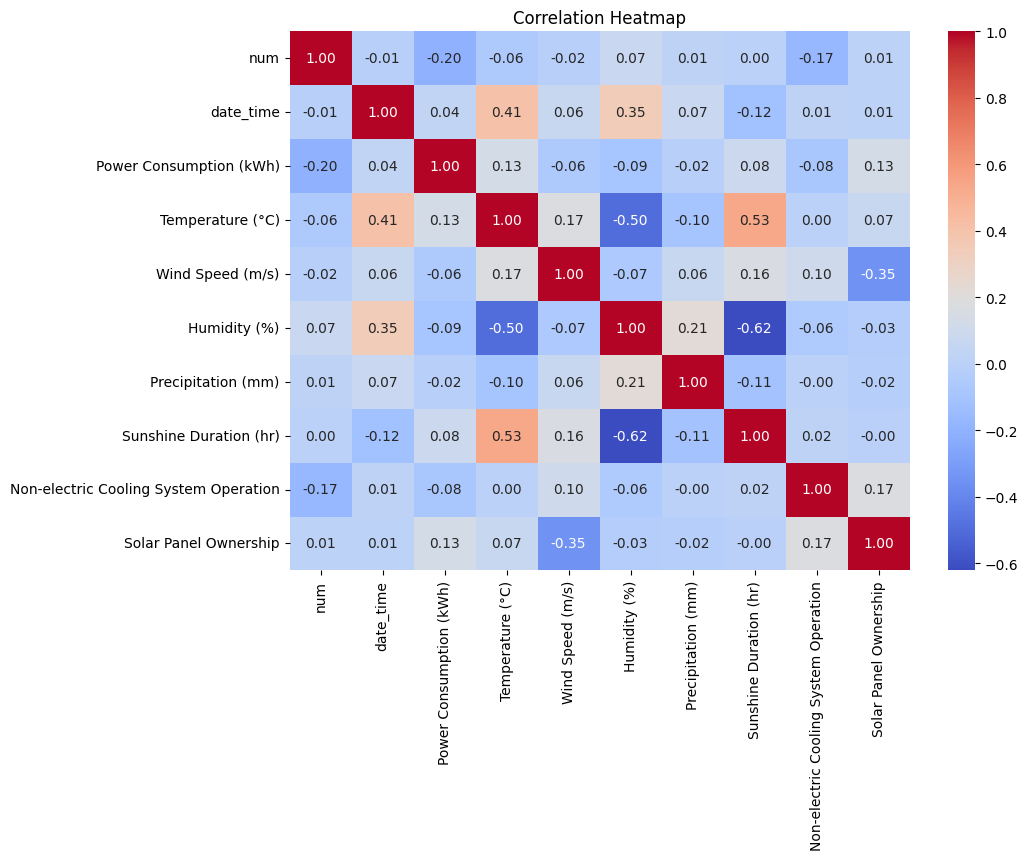

(17850, 9) (4463, 9)

--- [Model Comparison] ---
RandomForest:
  MSE: 646171.92
  MAE: 358.69
  R2 : 0.9307
GradientBoosting:
  MSE: 1451464.91
  MAE: 677.41
  R2 : 0.8443
XGBoost:
  MSE: 656687.93
  MAE: 428.50
  R2 : 0.9295
Ensemble(Voting):
  MSE: 764017.46
  MAE: 458.48
  R2 : 0.9180


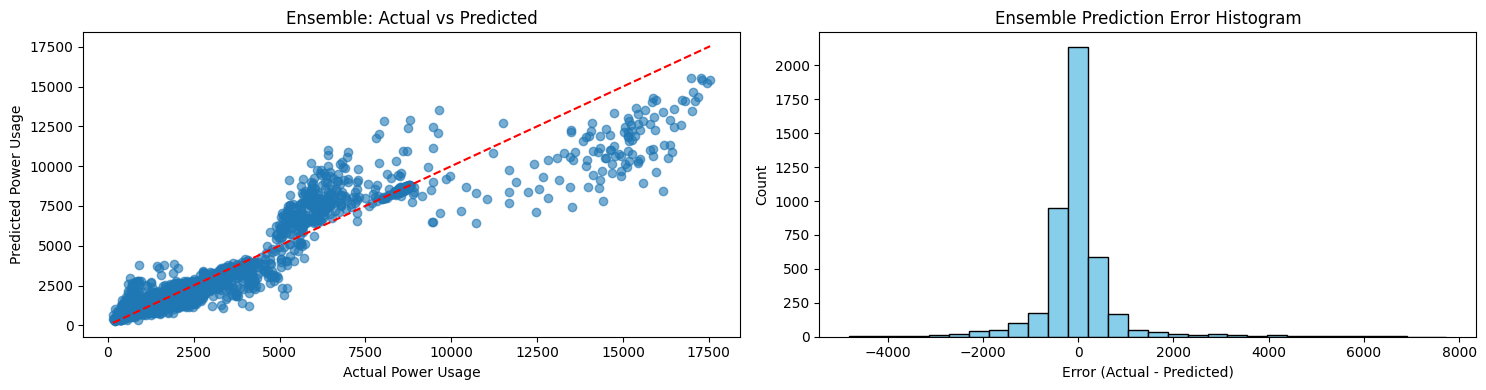

In [1]:
# 1. 라이브러리 및 데이터 로드
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Try reading with a different encoding
try:
    df = pd.read_csv('/content/train.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('/content/train.csv', encoding='cp949')


print(df.head())
print("컬럼:", df.columns)
print("결측치:\n", df.isnull().sum())

# 2. EDA 및 전처리
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("수치형:", num_cols)
print("범주형:", cat_cols)

# (전력사용량 컬럼 자동 탐색)
candidates = [c for c in df.columns if 'power' in c.lower() or 'usage' in c.lower() or 'target' in c.lower()]
target_col = candidates[0] if candidates else num_cols[-1]
print("예측 대상:", target_col)

# 결측치 처리
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 범주형 인코딩
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 상관관계 히트맵
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# 3. train/test split
y = df[target_col]
X = df.drop([target_col], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)

# 4. 앙상블 모델 (XGBoost, RF, GB, Ensemble)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost as xgb

rf = RandomForestRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
xgbm = xgb.XGBRegressor(n_estimators=100, random_state=42)

ensemble = VotingRegressor([('rf', rf), ('gbr', gbr), ('xgb', xgbm)])

ensemble.fit(X_train, y_train)
rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)
xgbm.fit(X_train, y_train)

# 5. 예측/평가/시각화
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def report(y_true, y_pred, name):
    print(f"{name}:")
    print(f"  MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"  MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"  R2 : {r2_score(y_true, y_pred):.4f}")

y_pred_ens = ensemble.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gbr = gbr.predict(X_test)
y_pred_xgb = xgbm.predict(X_test)

print("\n--- [Model Comparison] ---")
report(y_test, y_pred_rf, "RandomForest")
report(y_test, y_pred_gbr, "GradientBoosting")
report(y_test, y_pred_xgb, "XGBoost")
report(y_test, y_pred_ens, "Ensemble(Voting)")

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_ens, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Ensemble: Actual vs Predicted")
plt.xlabel("Actual Power Usage")
plt.ylabel("Predicted Power Usage")

plt.subplot(1,2,2)
plt.hist(y_test - y_pred_ens, bins=30, color='skyblue', edgecolor='k')
plt.title("Ensemble Prediction Error Histogram")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()